In [1]:
'''
this script evaluates full patched predictions and outputs confusion matrix and metrics
'''

'\nthis script evaluates full patched predictions and outputs confusion matrix and metrics\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import scipy.io as sio

In [3]:
## define global variables
VERSION = 1.1
NUM_CLASSES = 8
TILE_SIZE = 736
SAVED_MODEL_NAME = 'multiclass_unet_model_resnet50_40'

In [4]:
## path to data directories

# path to raw labels
gt_dir = r'\\babyserverdw3\PW Cloud Exp Documents\Lab work documenting\W-22-09-02 AT Establish HoverNet Training with freezing weights\dataset\Lymphocyte\0921 dataset\All\Raw Labels'

pred_dir = r'\\babyserverdw3\PW Cloud Exp Documents\Lab work documenting\W-22-09-10 AT Build Competent multi task DL model for tissue labeling\out\v{}\{}\patched'.format(VERSION, SAVED_MODEL_NAME)

eval_save_dir = r'\\babyserverdw3\PW Cloud Exp Documents\Lab work documenting\W-22-09-10 AT Build Competent multi task DL model for tissue labeling\out\v{}\{}\eval'.format(VERSION, SAVED_MODEL_NAME)

if not os.path.exists(eval_save_dir):
    os.mkdir(eval_save_dir)

processing FTE306-20X-normal...
processing FTE306-20X-STIC...
processing FTE307-20X-normal...
processing FTE307-20X-STIC...


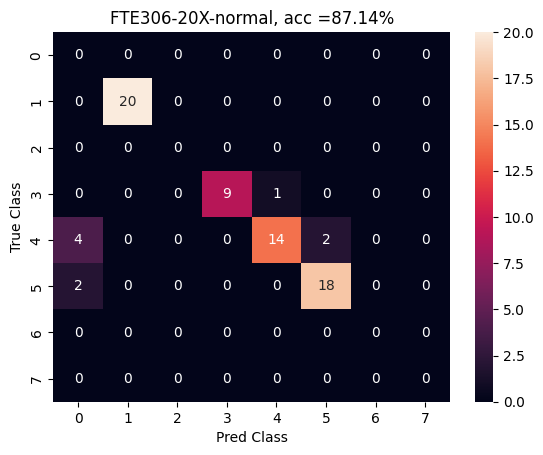

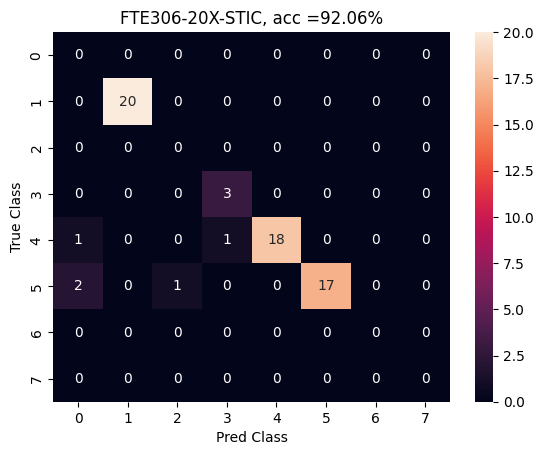

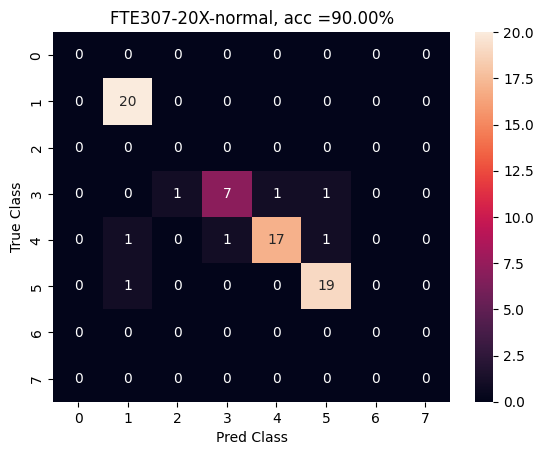

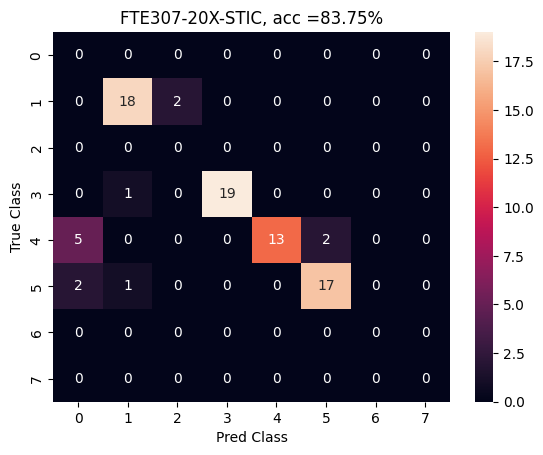

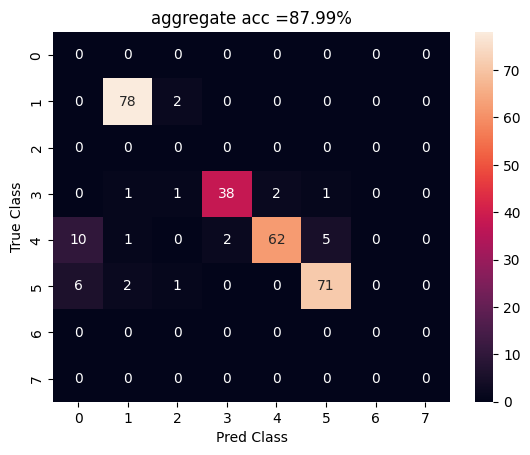

In [5]:
result_dict = {}
# aggregate confusion matrix
agg_cm = np.zeros((NUM_CLASSES, NUM_CLASSES)) # test only

for fn in os.listdir(pred_dir):
    im_name = fn[:-4]
    print('processing {}...'.format(im_name))
    # get predicted type map
    pred_tm = cv2.imread(os.path.join(pred_dir, fn), cv2.IMREAD_UNCHANGED)
    # get gt labels
    gt_fn = 'CellCounter_' + im_name + '.csv'
    gt_file = os.path.join(gt_dir, gt_fn)
    csvfile = pd.read_csv(gt_file)
    y_coord = np.array(csvfile['Y'].values)
    x_coord = np.array(csvfile['X'].values)
    true = np.array(csvfile['Type'].values)
    pred_type = pred_tm[y_coord, x_coord] # instances of predicted nuclei with gt labels
    
    pred = pred_type.squeeze()
    ## get accuracy and output confusion matrix
    acc = np.sum(pred == true) / len(pred)
    result_dict['accuracy'] = acc
    
    cm = confusion_matrix(true, pred)

    # ensure all confusion matrices have same dimensions
    for c in range(NUM_CLASSES):
        if (c not in pred) and (c not in true):
            # pad with zeros
            cm = np.insert(cm, c, 0, axis=1)
            cm = np.insert(cm, c, 0, axis=0)

    result_dict['conf_mat'] = cm
    
    plt.figure()
    g = sn.heatmap(cm, annot=True, fmt='.5g')
    plt.xlabel('Pred Class')
    plt.ylabel('True Class')
    plt.title('{}, acc ={:.2f}%'.format(im_name, acc*100))
    
    ## save figures for each image
    plt.savefig(os.path.join(eval_save_dir, '{}_CM.png'.format(im_name)))
    sio.savemat(os.path.join(eval_save_dir, '{}_eval.mat'.format(im_name)), mdict=result_dict)
    
    # add  to aggregate confusion matrix
    agg_cm = agg_cm + cm

agg_result_dict = {}
agg_result_dict['conf_mat'] = agg_cm
# compute aggregate accuracy
agg_acc = np.trace(agg_cm) / np.sum(agg_cm)
agg_result_dict['accuracy'] = agg_acc

plt.figure()
g = sn.heatmap(agg_cm, annot=True, fmt='.5g')
plt.xlabel('Pred Class')
plt.ylabel('True Class')
plt.title('aggregate acc ={:.2f}%'.format(agg_acc*100))
## save figures for each image
plt.savefig(os.path.join(eval_save_dir, 'aggregate_CM.png'))
sio.savemat(os.path.join(eval_save_dir, 'aggregate_eval.mat'), mdict=agg_result_dict)
